In [15]:
"""
Create a Spark Session

"""

from pyspark.sql import SparkSession
import pyarrow.parquet as pq
spark = (
    SparkSession.builder.appName("MAST30034 Assignment")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [16]:
# import curated data for SVM machine learning 
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


data = spark.read.parquet("data/curated/curated_yellow_taxi.parquet")
data = data.groupBy('date', 'hour', 'day of week', 'Borough', 'temp_categorized', 'event').count().drop('date')
data = data.filter(col('Borough') != "Unknown")

data.show()

+----+-----------+-------------+----------------+-----+-----+
|hour|day of week|      Borough|temp_categorized|event|count|
+----+-----------+-------------+----------------+-----+-----+
|   3|          7|        Bronx|            Cold|false|    5|
|   4|          5|          EWR|            Cold|false|    1|
|  14|          6|       Queens|            Cold|false|  891|
|  15|          6|    Manhattan|            Cold|false|15740|
|   7|          3|        Bronx|            Cold|false|   61|
|   9|          3|     Brooklyn|            Cold|false|  142|
|  15|          2|    Manhattan|            Cold|false|10635|
|   8|          5|          EWR|            Cold|false|    2|
|   6|          2|    Manhattan|            Cold|false| 6111|
|  23|          5|        Bronx|            Cold|false|   10|
|  13|          6|Staten Island|            Cold|false|    1|
|   5|          3|        Bronx|            Cold|false|   24|
|  17|          5|    Manhattan|            Cold|false|14982|
|  19|  

In [17]:
"""
Transform the count column into different categories of intensity

"""
from pyspark.sql.functions import col, when, split
import pandas as pd
from pyspark.ml.feature import StringIndexer
import numpy as np

data_count = data.select(col("count"))
data_count = data_count.toPandas()
data_count_column = data_count["count"].to_numpy()
sort_data_count = np.sort(data_count_column)
quantiles = np.percentile(sort_data_count, [20, 40, 60, 80])

# Define bucket boundaries based on quantiles
bucket_boundaries = [min(data_count["count"])] + quantiles.tolist() + [max(data_count["count"])]
# Assign category labels based on bucket boundaries
categories = pd.cut(data_count_column, bins=bucket_boundaries, labels=["very low", "low", "medium", "high", "very high"])

count_df = pd.DataFrame({'demand per hour': categories})
model_data = data.toPandas()[['hour', 'day of week', 'Borough', 'temp_categorized', 'event']]
model_data['demand per hour'] = count_df['demand per hour']

model_data = spark.createDataFrame(model_data)

# Use StringIndexer to label encode borough
string_indexer = StringIndexer(inputCol='Borough', outputCol='borough')
indexed = string_indexer.fit(model_data)
formatted_model = indexed.transform(model_data)

# Use StringIndexer to label encode temp
string_indexer = StringIndexer(inputCol='temp_categorized', outputCol='temp')
indexed = string_indexer.fit(model_data)
formatted_model = indexed.transform(formatted_model).drop("temp_categorized")

formatted_model.show()

+----+-----------+-------+-----+---------------+----+
|hour|day of week|borough|event|demand per hour|temp|
+----+-----------+-------+-----+---------------+----+
|   3|          7|    3.0|false|       very low| 1.0|
|   4|          5|    5.0|false|            NaN| 1.0|
|  14|          6|    2.0|false|           high| 1.0|
|  15|          6|    1.0|false|      very high| 1.0|
|   7|          3|    3.0|false|            low| 1.0|
|   9|          3|    0.0|false|         medium| 1.0|
|  15|          2|    1.0|false|      very high| 1.0|
|   8|          5|    5.0|false|       very low| 1.0|
|   6|          2|    1.0|false|      very high| 1.0|
|  23|          5|    3.0|false|       very low| 1.0|
|  13|          6|    4.0|false|            NaN| 1.0|
|   5|          3|    3.0|false|            low| 1.0|
|  17|          5|    1.0|false|      very high| 1.0|
|  19|          4|    4.0|false|            NaN| 1.0|
|  16|          7|    1.0|false|      very high| 1.0|
|   3|          7|    2.0|fa

In [18]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



# Split the data into training and testing sets
train_data, test_data = formatted_model.randomSplit([0.8, 0.2], seed=42)
train_data, test_data = train_data.toPandas(), test_data.toPandas()
#print(train_data)
#print(test_data)

x_cols = ["hour", "day of week", "borough", "temp", "event"]
target = "demand per hour"

trainX, trainY, testX, testY = train_data[x_cols], train_data[target], test_data[x_cols], test_data[target]



Accuracy: 0.8379156847342236
Precision: 0.8304657890267091
Recall: 0.8337015827318682
F1 Score: 0.8240088828081165


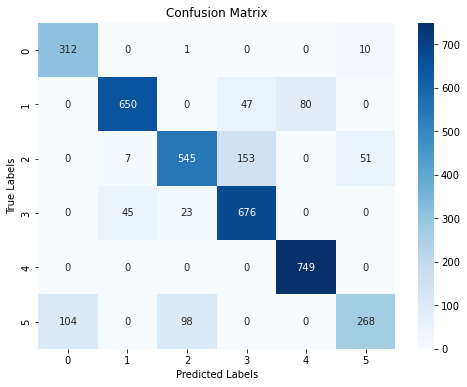

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Standardize the numerical features
scaler = StandardScaler()
trainX_scaled = scaler.fit_transform(trainX)
testX_scaled = scaler.transform(testX)

# Perform SVM 
svm_model = SVC(kernel='rbf')  
svm_model.fit(trainX_scaled, trainY)

y_pred = svm_model.predict(testX_scaled)

accuracy = accuracy_score(testY, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(testY, y_pred, average='macro')
recall = recall_score(testY, y_pred, average='macro')
f1 = f1_score(testY, y_pred, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

conf_matrix = confusion_matrix(testY, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


Accuracy: 0.8842628960460853
Precision: 0.8589319218547681
Recall: 0.861373903152062
F1 Score: 0.8596397483623829


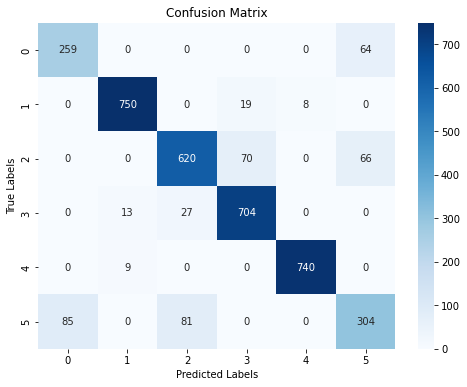

In [20]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

rf_model = RandomForestClassifier()
rf_model.fit(trainX_scaled, trainY)

y_pred = rf_model.predict(testX_scaled)

accuracy = accuracy_score(testY, y_pred)
print("Accuracy:", accuracy)

# Evaluation metric 
precision = precision_score(testY, y_pred, average='macro')
recall = recall_score(testY, y_pred, average='macro')
f1 = f1_score(testY, y_pred, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

conf_matrix_rf = confusion_matrix(testY, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()